In [1]:
from NoisyCircuits.utils.BuildQubitGateModelParallel import BuildModel as Parallel
from NoisyCircuits.utils.BuildQubitGateModelSingleOptimized import BuildModel as SingleOpt
from NoisyCircuits.utils.BuildQubitGateModel import BuildModel as Single
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse import identity, csr_matrix
with open("../noise_models/Noise_Model_Heron_QPU.pkl", "rb") as f:
    noise_model = pickle.load(f)

2026-02-06 15:46:56,975	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
vals_parallel = Parallel(
                    noise_model=noise_model,
                    num_qubits=2,
                    num_cores=2,
                    threshold=1e-15,
                    basis_gates=[["sx", "x", "rz", "rx"], ["cz", "rzz"]],
                    verbose=True).build_qubit_gate_model()

Available qubits in roerror_map: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
Requested qubits: [0, 1]
Completed Extraction of Measurement Errors.
Completed Extraction of two-qubit gate Errors.
Starting post-processing on Single Qubit Errors.
Completed post-processing on Single Qubit Errors.
Processing two-qubit gate errors.
Qubit pair (0, 1): 48/48 errors above threshold

In [3]:
def compare(n_qubits):

    def compare_sparse(mat1, mat2):
        mat1 = csr_matrix(mat1).toarray()
        mat2 = csr_matrix(mat2).toarray()
        return np.allclose(mat1, mat2)
    
    def compare_dictionaries(dict1, dict2):
        single_old, two_old = dict1
        single_new, two_new = dict2
        for qubit in single_old.keys():
            for gate in single_old[qubit].keys():
                kraus_ops_new = single_new[qubit][gate]["kraus_operators"]
                kraus_ops_old = single_old[qubit][gate]["kraus_operators"]
                for k in range(len(kraus_ops_new)):
                    assert compare_sparse(kraus_ops_new[k], kraus_ops_old[k]), f"Single qubit gate mismatch on qubit {qubit} gate {gate} operator {k}"
                qubit_channel_new = single_new[qubit][gate]["qubit_channel"]
                qubit_channel_old = single_old[qubit][gate]["qubit_channel"]
                for k in range(len(qubit_channel_new)):
                    assert compare_sparse(qubit_channel_new[k], qubit_channel_old[k]), f"Single qubit channel mismatch on qubit {qubit} gate {gate} operator {k}"
            
        for gate in two_old.keys():
            for qubit_pair in two_old[gate].keys():
                kraus_ops_new = two_new[gate][qubit_pair]["operators"]
                kraus_ops_old = two_old[gate][qubit_pair]["operators"]
                for k in range(len(kraus_ops_new)):
                    assert compare_sparse(kraus_ops_new[k], kraus_ops_old[k]), f"Two qubit gate mismatch on qubits {qubit_pair} gate {gate} operator {k}"
                gate_channel_new = two_new[gate][qubit_pair]["qubit_channel"]
                gate_channel_old = two_old[gate][qubit_pair]["qubit_channel"]
                for k in range(len(gate_channel_new)):
                    assert compare_sparse(gate_channel_new[k], gate_channel_old[k]), f"Two qubit channel mismatch on qubits {qubit_pair} gate {gate} operator {k}"
        return True
    
    time_data = {
        # "Old" : [],
        "Single": [],
        "Parallel": []
    }
    for _ in range(3):
        # t0 = time.perf_counter_ns()
        # vals_old = Single(
        #             noise_model=noise_model,
        #             num_qubits=n_qubits,
        #             threshold=1e-15,
        #             basis_gates=[["sx", "x", "rz", "rx"], ["cz", "rzz"]],
        #             verbose=False).build_qubit_gate_model()
        # t1 = time.perf_counter_ns()
        # time_data["Old"].append(t1 - t0)
        t0 = time.perf_counter_ns()
        vals_single = SingleOpt(
                    noise_model=noise_model,
                    num_qubits=n_qubits,
                    num_cores=n_qubits,
                    threshold=1e-15,
                    basis_gates=[["sx", "x", "rz", "rx"], ["cz", "rzz"]],
                    verbose=False).build_qubit_gate_model()
        t1 = time.perf_counter_ns()
        time_data["Single"].append(t1 - t0)
        t0 = time.perf_counter_ns()
        vals_parallel = Parallel(
                    noise_model=noise_model,
                    num_qubits=n_qubits,
                    num_cores=n_qubits,
                    threshold=1e-15,
                    basis_gates=[["sx", "x", "rz", "rx"], ["cz", "rzz"]],
                    verbose=False).build_qubit_gate_model()
        t1 = time.perf_counter_ns()
        time_data["Parallel"].append(t1 - t0)
    # single_old, two_old, _, _ = vals_old
    single_single, two_single, _, _ = vals_single
    single_parallel, two_parallel, _, _ = vals_parallel
    # if compare_dictionaries((single_old, two_old), (single_single, two_single)) and compare_dictionaries((single_old, two_old), (single_parallel, two_parallel)):
    #     return time_data
    return time_data

In [4]:
qubits_data = {
    "qubits":[],
    "mean": [[], []],
    "std": [[], []]
}
for n_qubits in range(1, 14):
    data = compare(n_qubits)
    qubits_data["qubits"].append(n_qubits)
    for i, key in enumerate(["Single", "Parallel"]):
        qubits_data["mean"][i].append(np.mean(data[key]) / 1e9)
        qubits_data["std"][i].append(np.std(data[key]) / 1e9)

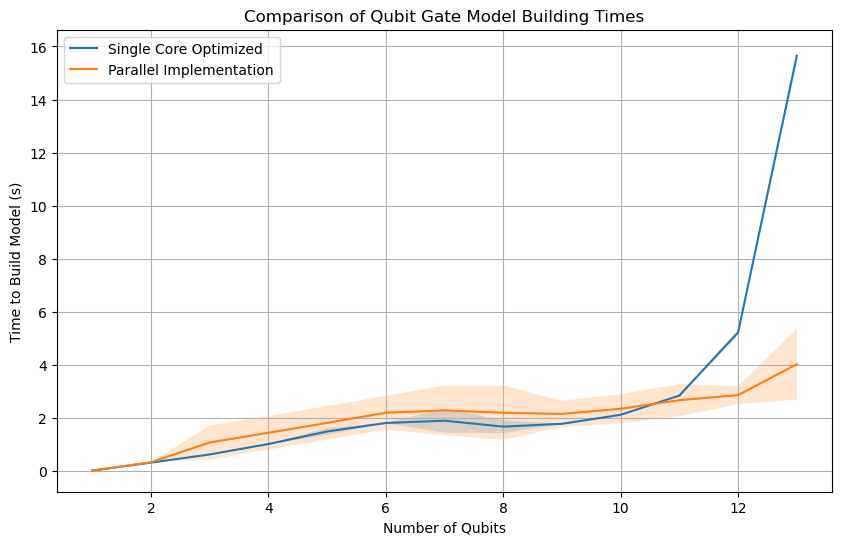

In [5]:
plt.figure(figsize=(10, 6))
label_list = ["Single Core Optimized", "Parallel Implementation"]
for i in range(2):
    plt.plot(qubits_data["qubits"], qubits_data["mean"][i], label=label_list[i])
    plt.fill_between(qubits_data["qubits"],
                     np.array(qubits_data["mean"][i]) - np.array(qubits_data["std"][i]),
                     np.array(qubits_data["mean"][i]) + np.array(qubits_data["std"][i]),
                     alpha=0.2)
plt.xlabel("Number of Qubits")
plt.ylabel("Time to Build Model (s)")
plt.title("Comparison of Qubit Gate Model Building Times")
plt.legend()
plt.grid()
plt.show()

In [5]:
for i in range(len(qubits_data["qubits"])):
    print("Data For {} Qubits:".format(qubits_data["qubits"][i]))
    # print("Old Implementation Mean: {} s".format(qubits_data["mean"][0][i]))
    print("Single Core Optimized Mean: {} s".format(qubits_data["mean"][0][i]))
    print("Parallel Implementation Mean: {} s".format(qubits_data["mean"][1][i]))

Data For 1 Qubits:
Single Core Optimized Mean: 0.02753086266666667 s
Parallel Implementation Mean: 0.024925332 s
Data For 2 Qubits:
Single Core Optimized Mean: 0.11401697133333333 s
Parallel Implementation Mean: 0.438104081 s
Data For 3 Qubits:
Single Core Optimized Mean: 0.21223536866666665 s
Parallel Implementation Mean: 0.5697449513333334 s
Data For 4 Qubits:
Single Core Optimized Mean: 0.3428471666666667 s
Parallel Implementation Mean: 0.6834826756666667 s
Data For 5 Qubits:
Single Core Optimized Mean: 0.48038660866666666 s
Parallel Implementation Mean: 0.869661135 s
Data For 6 Qubits:
Single Core Optimized Mean: 0.6434547546666666 s
Parallel Implementation Mean: 0.964475248 s
Data For 7 Qubits:
Single Core Optimized Mean: 0.8824137573333334 s
Parallel Implementation Mean: 1.1800907846666668 s
Data For 8 Qubits:
Single Core Optimized Mean: 1.261882838 s
Parallel Implementation Mean: 1.3963792226666667 s
Data For 9 Qubits:
Single Core Optimized Mean: 1.5125879673333333 s
Parallel Im

In [6]:
for i in range(len(qubits_data["qubits"])):
    print("Data For {} Qubits:".format(qubits_data["qubits"][i]))
    # print("Old Implementation Mean: {} s".format(qubits_data["mean"][0][i]))
    print("Single Core Optimized Mean: {} s".format(qubits_data["mean"][0][i]))
    print("Parallel Implementation Mean: {} s".format(qubits_data["mean"][1][i]))

Data For 1 Qubits:
Single Core Optimized Mean: 0.030751258 s
Parallel Implementation Mean: 0.026921576333333332 s
Data For 2 Qubits:
Single Core Optimized Mean: 0.3286391206666667 s
Parallel Implementation Mean: 0.343392508 s
Data For 3 Qubits:
Single Core Optimized Mean: 0.636644151 s
Parallel Implementation Mean: 1.0880827006666667 s
Data For 4 Qubits:
Single Core Optimized Mean: 1.0282031403333334 s
Parallel Implementation Mean: 1.4522851563333332 s
Data For 5 Qubits:
Single Core Optimized Mean: 1.5015491473333333 s
Parallel Implementation Mean: 1.8250647716666668 s
Data For 6 Qubits:
Single Core Optimized Mean: 1.8209137203333332 s
Parallel Implementation Mean: 2.207435258 s
Data For 7 Qubits:
Single Core Optimized Mean: 1.9077219186666667 s
Parallel Implementation Mean: 2.2944109036666664 s
Data For 8 Qubits:
Single Core Optimized Mean: 1.684011497 s
Parallel Implementation Mean: 2.2063862493333333 s
Data For 9 Qubits:
Single Core Optimized Mean: 1.7900752813333332 s
Parallel Impl